### Author: KR
### Date: 05/25/2025

# Topic: Predicting Equipment Failure Using Sensor Data

### Business Problem:

Unexpected equipment failures can cause costly interruptions in manufacturing and production environments. Being able to predict when a failure is likely to occur allows for proactive maintenance and reduces the risk of system-wide disruptions.

### Import Libraries and Load the Dataset

In [5]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Load the dataset
df = pd.read_csv("predictive_maintenance.csv")

In [9]:
# Display the first few rows
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551.0,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408.0,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498.0,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433.0,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408.0,40.0,9,0,No Failure


### Data Preparation

In [12]:
# Check basic structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     9800 non-null   object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   9700 non-null   float64
 6   Torque [Nm]              9700 non-null   float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(4), int64(3), object(3)
memory usage: 781.4+ KB


In [14]:
# Summary statistics
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,9700.000000,9700.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.666598,39.972082,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.037065,9.979572,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.700000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [16]:
# Check for missing values
df.isnull().sum()

UDI                          0
Product ID                   0
Type                       200
Air temperature [K]          0
Process temperature [K]      0
Rotational speed [rpm]     300
Torque [Nm]                300
Tool wear [min]              0
Target                       0
Failure Type                 0
dtype: int64

In [18]:
# Drop UDI and Product ID
df = df.drop(columns=["UDI", "Product ID"])

In [20]:
# Drop rows with missing values
df = df.dropna()

In [22]:
# Confirm missing values are handled
df.isnull().sum()

Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [24]:
# Check for duplicates
df.duplicated().sum()

0

### Exploratory Data Analysis (EDA)

In [27]:
# Count of each class
df['Target'].value_counts()

0    8917
1     305
Name: Target, dtype: int64

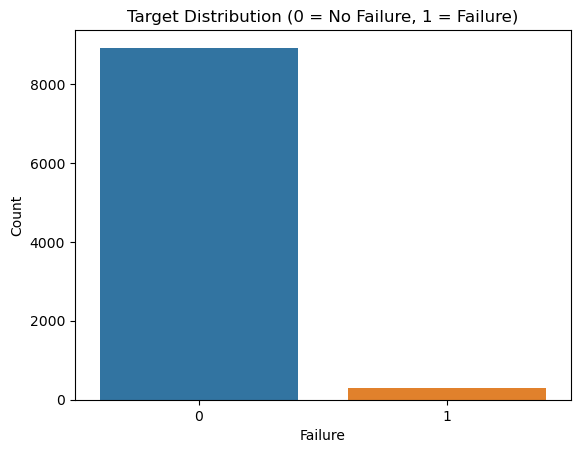

In [29]:
# Plot the class distribution
sns.countplot(data=df, x='Target')
plt.title('Target Distribution (0 = No Failure, 1 = Failure)')
plt.xlabel('Failure')
plt.ylabel('Count')
plt.show()

Target Distribution (0 = No Failure, 1 = Failure)  
- The dataset is highly imbalanced, with a large majority of machines not failing (Target = 0) and only a small number failing (Target = 1). This confirms the need to use precision/recall or class weighting during model evaluation since accuracy alone may be misleading.

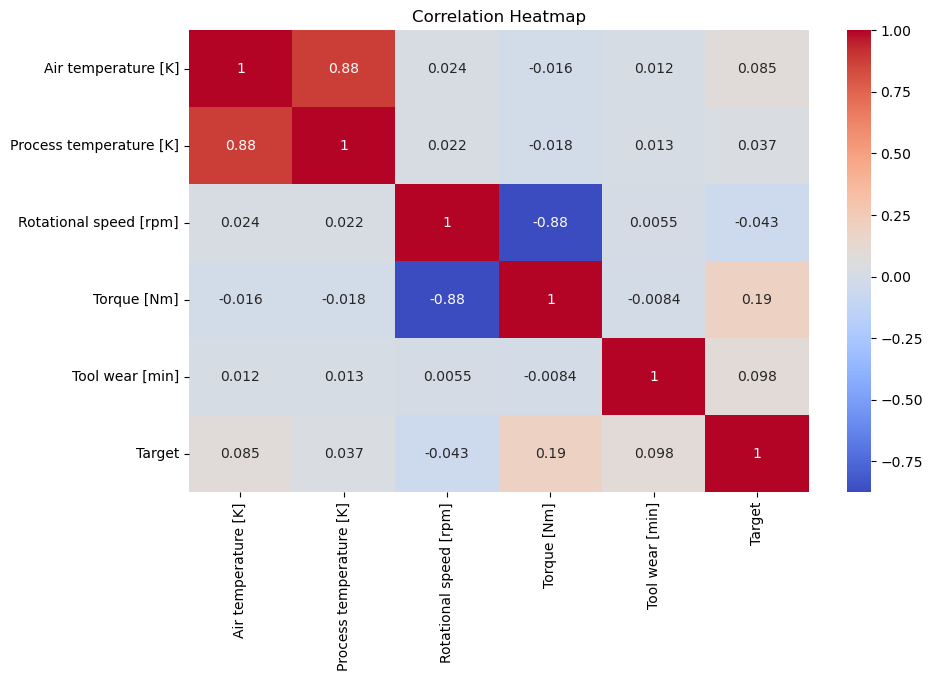

In [31]:
# Correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Correlation Heatmap
- Torque and Rotational speed are strongly negatively correlated (−0.88), which could indicate a mechanical tradeoff.
- Most sensor variables have weak correlation with Target (failure), but Torque (0.19) and Tool wear (0.098) show the highest positive correlation with failures.

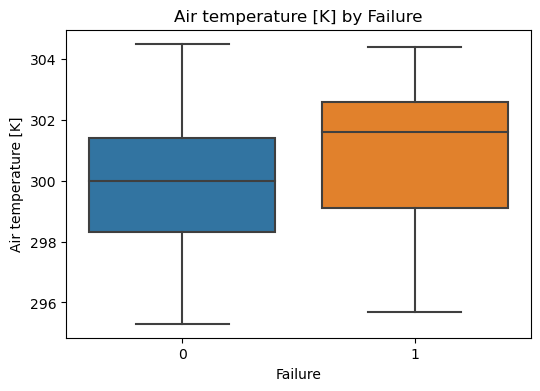

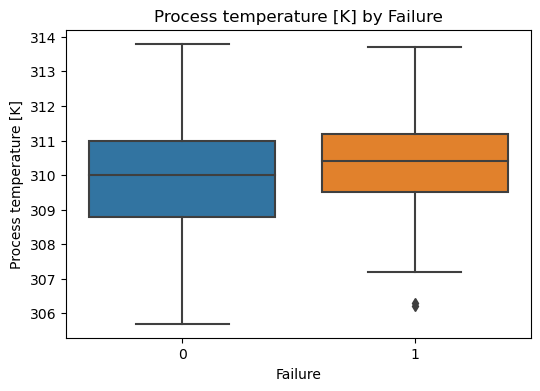

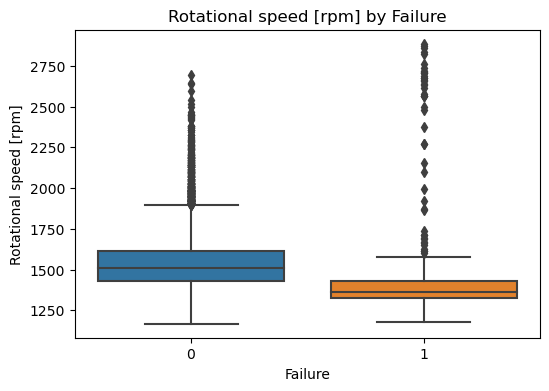

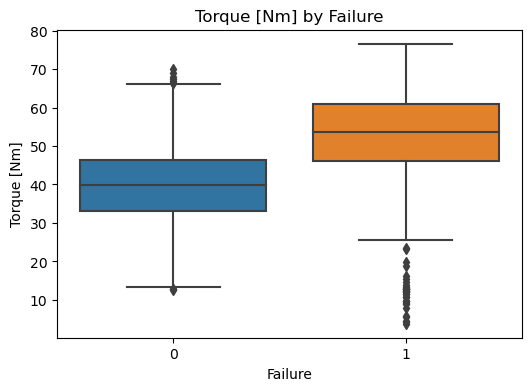

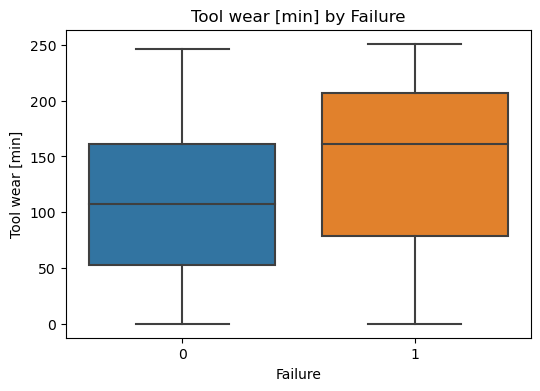

In [33]:
# Boxplots for selected features
features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
            'Torque [Nm]', 'Tool wear [min]']

for feature in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x='Target', y=feature)
    plt.title(f'{feature} by Failure')
    plt.xlabel('Failure')
    plt.ylabel(feature)
    plt.show()

Highlights:
- Air Temperature by Failure: Failed machines tend to operate at slightly higher air temperatures on average.
- Process Temperature by Failure: There’s a minor increase in median process temperature for failed machines.
- Rotational Speed by Failure: Failed machines tend to have lower rotational speeds.
- Torque by Failure: Machines that fail show higher torque values, with a noticeably different distribution.
- Tool Wear by Failure: Tool wear is significantly higher in failed machines.

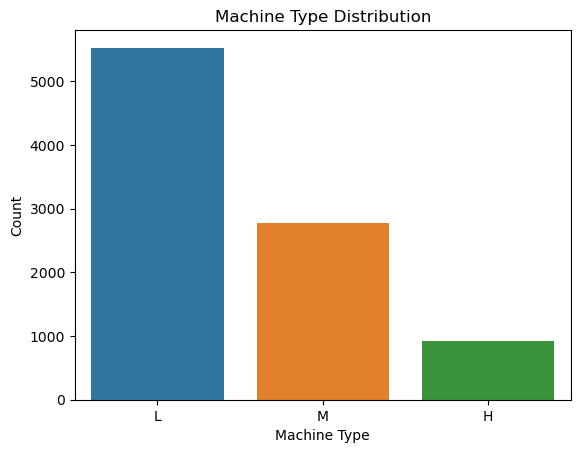

In [35]:
# Count plot of machine types
sns.countplot(data=df, x='Type', order=df['Type'].value_counts().index)
plt.title('Machine Type Distribution')
plt.xlabel('Machine Type')
plt.ylabel('Count')
plt.show()

Machine Type Distribution
- Most machines in the dataset are Type L, followed by M and a small number of H type machines. Since machine type may affect wear, speed, or torque, we’ll need to encode this feature properly before modeling (e.g., one-hot encoding).

### Modeling: Random Forest

In [47]:
# One-hot encode the 'Type' column
df_encoded = pd.get_dummies(df, columns=['Type'], drop_first=True)

# Preview the updated dataframe
df_encoded.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Type_L,Type_M
0,298.1,308.6,1551.0,42.8,0,0,No Failure,0,1
1,298.2,308.7,1408.0,46.3,3,0,No Failure,1,0
2,298.1,308.5,1498.0,49.4,5,0,No Failure,1,0
3,298.2,308.6,1433.0,39.5,7,0,No Failure,1,0
4,298.2,308.7,1408.0,40.0,9,0,No Failure,1,0


In [49]:
# Define features and target
X = df_encoded.drop(columns=['Target', 'Failure Type'])
y = df_encoded['Target']

In [51]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [53]:
# Create and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1, class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=1)

In [55]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["No Failure", "Failure"]))

Confusion Matrix:
[[1782    2]
 [  33   28]]

Classification Report:
              precision    recall  f1-score   support

  No Failure       0.98      1.00      0.99      1784
     Failure       0.93      0.46      0.62        61

    accuracy                           0.98      1845
   macro avg       0.96      0.73      0.80      1845
weighted avg       0.98      0.98      0.98      1845



Random Forest Model – Evaluation  
  
- True Negatives (TN = 1782): Machines correctly predicted as not failing.
- False Positives (FP = 2): Machines incorrectly predicted as failures.
- False Negatives (FN = 33): Machines that failed but were not predicted to fail.
- True Positives (TP = 28): Machines correctly predicted to fail.

The Random Forest model achieved a high overall accuracy of 98%, indicating strong performance in classifying machine status. However, this result is influenced by the class imbalance, as most machines in the dataset did not experience failure. The model showed high precision (93%) for predicting failures, meaning that when it flagged a failure, it was usually correct. On the other hand, the recall for the failure class was 46%, indicating that it correctly identified less than half of the actual failures. This suggests that while the model is reliable in terms of minimizing false alarms, it may miss some true failure cases. Overall, the model performs very well in detecting normal operations and has potential to support predictive maintenance, although recall could be improved with further tuning.